<a href="https://colab.research.google.com/github/bilalProgTech/mtech-nmims/blob/master/speech-recognition/Lab-Work/20221016-Lab-10-MTech-AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR']='/content'
!kaggle datasets download -d kongaevans/speaker-recognition-dataset
!unzip *.zip

In [2]:
import tensorflow as tf
import librosa
import librosa.display
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, log_loss, confusion_matrix
import IPython.display as ipd

In [3]:
ipd.Audio('/content/16000_pcm_speeches/Nelson_Mandela/101.wav')

In [4]:
ipd.Audio('/content/16000_pcm_speeches/Magaret_Tarcher/101.wav')

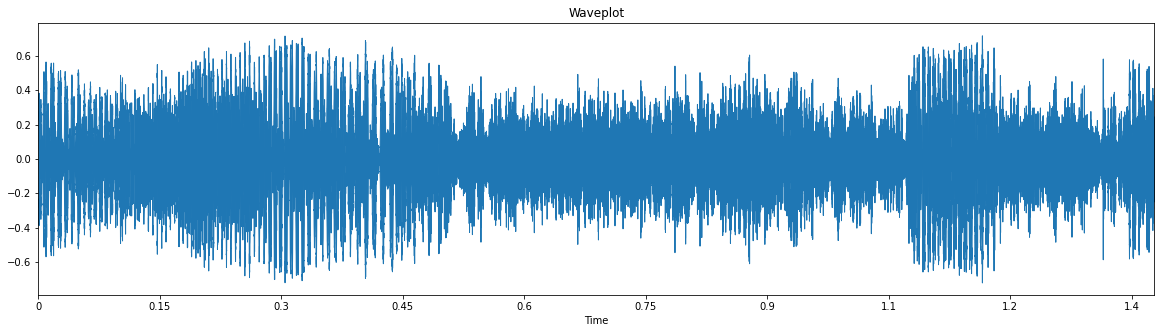

In [5]:
path = '/content/16000_pcm_speeches/Nelson_Mandela/101.wav'
x , sr = librosa.load(path)
plt.figure(figsize=(20, 5))
plt.title('Waveplot')
librosa.display.waveplot(x, sr=16000)
plt.show()

In [6]:
x.shape, x.reshape(-1, 1).shape

((22050,), (22050, 1))

In [7]:
files = []
speaker_list = []
speakers_list = ['Benjamin_Netanyau', 'Jens_Stoltenberg', 'Julia_Gillard', 'Magaret_Tarcher', 'Nelson_Mandela']
for dirname, _, filenames in os.walk('/content/16000_pcm_speeches/'):
    for filename in filenames:
        filepath = os.path.join(dirname, filename)
        speaker = filepath.split('/')[-2]
        if speaker in speakers_list:
            speaker_list.append(speaker)
            files.append(filepath)
data = pd.DataFrame({'filename': files, 'speaker':speaker_list})
data = data.sample(frac=1)
data = data.reset_index(drop=True)
data.head()

,filename,speaker
0,/content/16000_pcm_speeches/Julia_Gillard/607.wav,Julia_Gillard
1,/content/16000_pcm_speeches/Julia_Gillard/558.wav,Julia_Gillard
2,/content/16000_pcm_speeches/Magaret_Tarcher/68...,Magaret_Tarcher
3,/content/16000_pcm_speeches/Julia_Gillard/1004...,Julia_Gillard
4,/content/16000_pcm_speeches/Jens_Stoltenberg/7...,Jens_Stoltenberg


In [8]:
data['speaker'].value_counts()

Julia_Gillard        1501
Magaret_Tarcher      1500
Jens_Stoltenberg     1500
Nelson_Mandela       1500
Benjamin_Netanyau    1500
Name: speaker, dtype: int64

In [9]:
train, test = train_test_split(data, test_size=0.20)

In [10]:
encoder = LabelEncoder()
encoder.fit(data['speaker'])
y_train = encoder.transform(train['speaker'].values)
y_train = tf.keras.utils.to_categorical(y_train)
y_test = encoder.transform(test['speaker'].values)
y_test = tf.keras.utils.to_categorical(y_test)
y_train.shape, y_test.shape

((6000, 5), (1501, 5))

In [11]:
file_count = 0
x_train_new = np.zeros((train.shape[0], 126, 60), dtype=np.float64)
try:
    for count_, path in zip(range(train.shape[0]), train['filename'].values):
        x , sr = librosa.load(path)
        mfcc = librosa.feature.mfcc(y=x, sr=16000, hop_length=128, n_fft=256, n_mfcc=20)
        mfcc_delta = librosa.feature.delta(mfcc)
        mfcc_double_delta = librosa.feature.delta(mfcc, order=2)
        x_train_new[count_, :, :20] = mfcc.T[:126,]
        x_train_new[count_, :, 20:40] = mfcc_delta.T[:126,]
        x_train_new[count_, :, 40:] = mfcc_double_delta.T[:126,]
        count_ += 1
except:
    print('Error reading audio')

/usr/local/lib/python3.7/dist-packages/librosa/filters.py:239: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  "Empty filters detected in mel frequency basis. "


In [12]:
x_train_new.shape

(6000, 126, 60)

In [13]:
file_count = 0
x_test_new = np.zeros((test.shape[0], 126, 60), dtype=np.float64)
try:
    for count_, path in zip(range(test.shape[0]), test['filename'].values):
        x , sr = librosa.load(path)
        mfcc = librosa.feature.mfcc(y=x, sr=16000, hop_length=128, n_fft=256, n_mfcc=20)
        mfcc_delta = librosa.feature.delta(mfcc)
        mfcc_double_delta = librosa.feature.delta(mfcc, order=2)
        x_test_new[count_, :, :20] = mfcc.T[:126,]
        x_test_new[count_, :, 20:40] = mfcc_delta.T[:126,]
        x_test_new[count_, :, 40:] = mfcc_double_delta.T[:126,]
        count_ += 1
except:
    print('Error reading audio')

In [14]:
x_test_new.shape

(1501, 126, 60)

In [15]:
tf.keras.backend.clear_session()
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(126, 60, 1)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(len(data['speaker'].unique()), activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 124, 58, 128)      1280      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 62, 29, 128)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 27, 64)        73792     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 13, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 24960)             0         
                                                                 
 dense (Dense)               (None, 5)                 1

In [16]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [17]:
history = model.fit(x_train_new, y_train, epochs=20)

Epoch 1/20
188/188 [==============================] - 10s 18ms/step - loss: 1.4342 - accuracy: 0.5697
Epoch 2/20
188/188 [==============================] - 4s 20ms/step - loss: 0.4236 - accuracy: 0.8358
Epoch 3/20
188/188 [==============================] - 3s 17ms/step - loss: 0.3057 - accuracy: 0.8845
Epoch 4/20
188/188 [==============================] - 3s 17ms/step - loss: 0.2517 - accuracy: 0.9087
Epoch 5/20
188/188 [==============================] - 3s 17ms/step - loss: 0.2663 - accuracy: 0.9068
Epoch 6/20
188/188 [==============================] - 3s 17ms/step - loss: 0.1955 - accuracy: 0.9268
Epoch 7/20
188/188 [==============================] - 3s 17ms/step - loss: 0.1846 - accuracy: 0.9323
Epoch 8/20
188/188 [==============================] - 3s 17ms/step - loss: 0.1985 - accuracy: 0.9290
Epoch 9/20
188/188 [==============================] - 3s 17ms/step - loss: 0.1956 - accuracy: 0.9353
Epoch 10/20
188/188 [==============================] - 3s 17ms/step - loss: 0.1743 - accur

In [18]:
model.evaluate(x_test_new, y_test)

47/47 [==============================] - 1s 11ms/step - loss: 0.2913 - accuracy: 0.9201


[0.29131609201431274, 0.9200533032417297]

In [19]:
prob_test = model.predict(x_test_new)
pred_test = np.argmax(prob_test, axis=1)
pred_test = encoder.inverse_transform(pred_test)

47/47 [==============================] - 0s 6ms/step


In [22]:
confusion_matrix(encoder.inverse_transform(np.argmax(y_test, axis=1)), pred_test)

array([[257,  29,   1,  22,   0],
       [ 10, 267,  15,   1,   1],
       [  4,   8, 289,   2,  10],
       [  7,   3,   4, 286,   0],
       [  0,   0,   3,   0, 282]])

In [ ]:
!pip install praat-parselmouth

In [6]:
import parselmouth

In [13]:
import os
os.environ['KAGGLE_CONFIG_DIR']='/content'
!kaggle datasets download -d ejlok1/toronto-emotional-speech-set-tess

 94% 401M/428M [00:02<00:00, 200MB/s]
100% 428M/428M [00:02<00:00, 152MB/s]


In [ ]:
!unzip toronto-emotional-speech-set-tess.zip

In [22]:
ipd.Audio('/content/TESS Toronto emotional speech set data/OAF_happy/OAF_back_happy.wav')

In [26]:
ipd.Audio('/content/TESS Toronto emotional speech set data/YAF_angry/YAF_back_angry.wav')

# Pitch Frequency

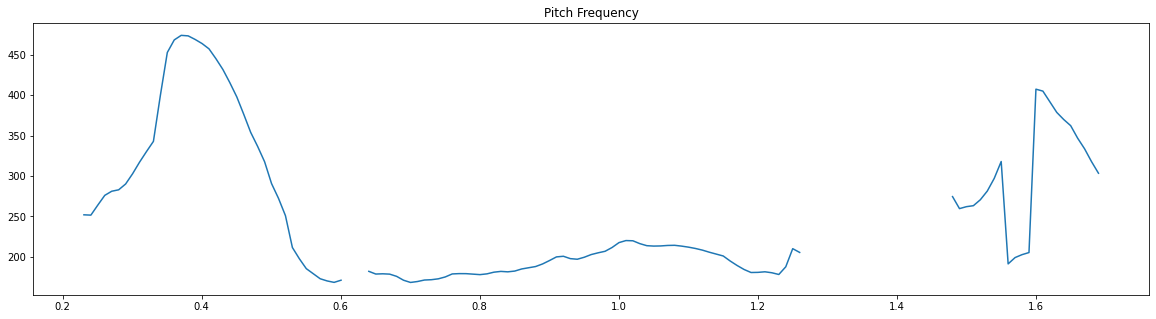

In [15]:
path = '/content/TESS Toronto emotional speech set data/OAF_happy/OAF_back_happy.wav'
sound = parselmouth.Sound(path)
pitch = sound.to_pitch(time_step=0.01)
times = pitch.ts()

pitch_data = []
for dt in times:
    pitch_data.append(pitch.get_value_at_time(dt))

plt.figure(figsize=(20, 5))
plt.title('Pitch Frequency')
plt.plot(times, pitch_data)
plt.show()

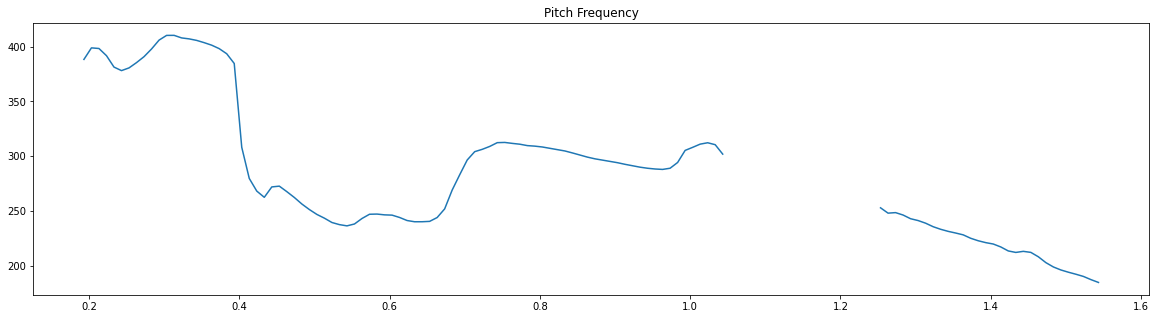

In [16]:
path = '/content/TESS Toronto emotional speech set data/YAF_happy/YAF_back_happy.wav'
sound = parselmouth.Sound(path)
pitch = sound.to_pitch(time_step=0.01)
times = pitch.ts()

pitch_data = []
for dt in times:
    pitch_data.append(pitch.get_value_at_time(dt))

plt.figure(figsize=(20, 5))
plt.title('Pitch Frequency')
plt.plot(times, pitch_data)
plt.show()

# Intensity

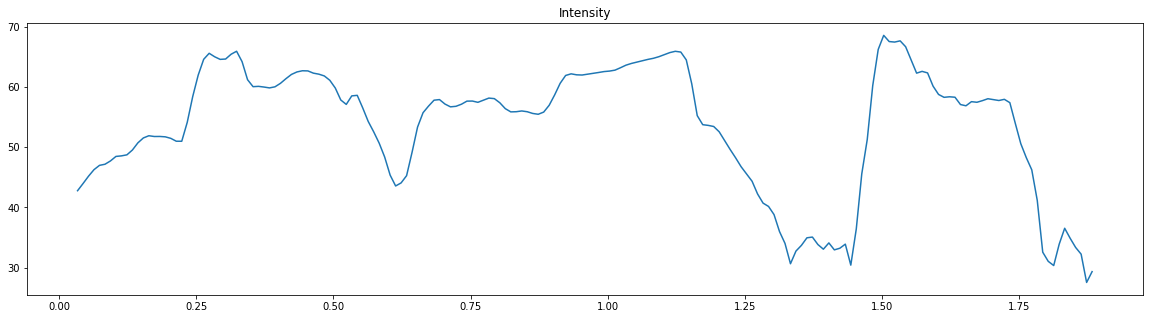

In [18]:
path = '/content/TESS Toronto emotional speech set data/OAF_happy/OAF_back_happy.wav'
sound = parselmouth.Sound(path)
intensity = sound.to_intensity(time_step=0.01)

intensity_data = []
for dt in times:
    intensity_data.append(intensity.get_value(dt))

plt.figure(figsize=(20, 5))
plt.title('Intensity')
plt.plot(times, intensity_data)
plt.show()

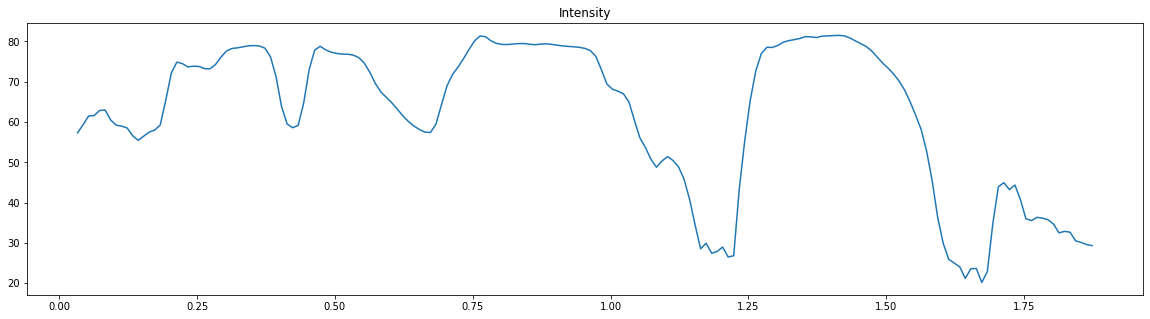

In [19]:
path = '/content/TESS Toronto emotional speech set data/YAF_happy/YAF_back_happy.wav'
sound = parselmouth.Sound(path)
intensity = sound.to_intensity(time_step=0.01)

intensity_data = []
for dt in times:
    intensity_data.append(intensity.get_value(dt))

plt.figure(figsize=(20, 5))
plt.title('Intensity')
plt.plot(times, intensity_data)
plt.show()

# Formants - Resonance

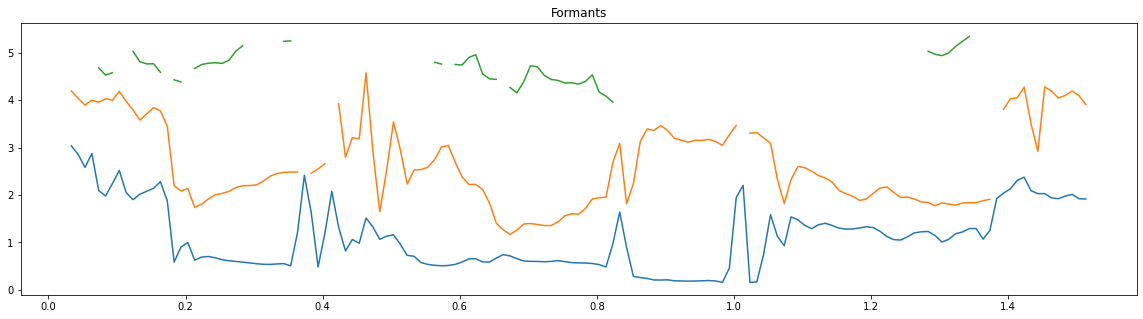

In [24]:
path = '/content/TESS Toronto emotional speech set data/OAF_angry/OAF_back_angry.wav'
sound = parselmouth.Sound(path)
formants = sound.to_formant_burg(time_step=0.01, max_number_of_formants=3)

formant_1 = []
formant_2 = []
formant_3 = []

for dt in times:
    formant_1.append(formants.get_value_at_time(1, dt))
    formant_2.append(formants.get_value_at_time(2, dt))
    formant_3.append(formants.get_value_at_time(3, dt))


plt.figure(figsize=(20, 5))
plt.title('Formants')
plt.plot(times, np.array(formant_1)/1e3)
plt.plot(times, np.array(formant_2)/1e3)
plt.plot(times, np.array(formant_3)/1e3)
plt.show()

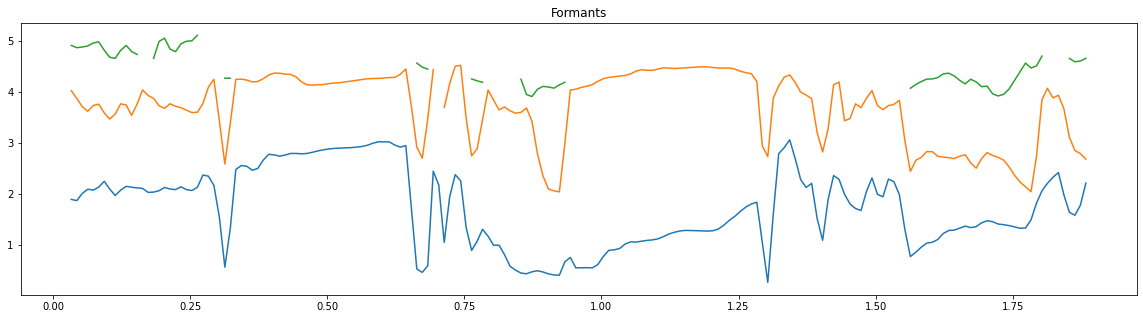

In [25]:
path = '/content/TESS Toronto emotional speech set data/YAF_angry/YAF_back_angry.wav'

sound = parselmouth.Sound(path)
formants = sound.to_formant_burg(time_step=0.01, max_number_of_formants=3)

formant_1 = []
formant_2 = []
formant_3 = []

for dt in times:
    formant_1.append(formants.get_value_at_time(1, dt))
    formant_2.append(formants.get_value_at_time(2, dt))
    formant_3.append(formants.get_value_at_time(3, dt))


plt.figure(figsize=(20, 5))
plt.title('Formants')
plt.plot(times, np.array(formant_1)/1e3)
plt.plot(times, np.array(formant_2)/1e3)
plt.plot(times, np.array(formant_3)/1e3)
plt.show()